In [51]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import multivariate_normal
from sklearn.neighbors import KNeighborsClassifier

# Environment

#### Noisy Cart Pole

This is the noisy version of the CartPole-v0 environment of OpenAI.  
https://gym.openai.com/envs/CartPole-v0  
https://github.com/openai/gym/wiki/CartPole-v0  


In [52]:
class NoisyCartPoleEnvironment:
    
    state_dimension = 4
    action_dimension = 1
    action_space = range(2)
    transition_sigmas = [ 1e-2, 1e-5, 1e-2, 1e-5 ]
    transition_covariance = np.diagflat(transition_sigmas)
    logp_mean = (-1/2) * np.log(np.linalg.det(2*np.pi*transition_covariance))
    
    def __init__(self):
        pass
    
    def cartpole_reset(self):
        state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        return np.array(state)
    
    # Extracted from OpenAI environment CartPole-v0
    def cartpole_step(self, state, action):

        gravity = 9.8
        masscart = 1.0
        masspole = 0.1
        total_mass = (masspole + masscart)
        length = 0.5 # actually half the pole's length
        polemass_length = (masspole * length)
        force_mag = 10.0
        tau = 0.02  # seconds between state updates

        # Angle at which to fail the episode
        theta_threshold_radians = 12 * 2 * math.pi / 360
        x_threshold = 2.4

        x, x_dot, theta, theta_dot = state

        already_done =  x < -x_threshold \
            or x > x_threshold \
            or theta < -theta_threshold_radians \
            or theta > theta_threshold_radians
        already_done = bool(already_done)

        if already_done:

            next_state = state
            reward = 0
            done = True

        else:

            force = force_mag if action==1 else -force_mag
            costheta = math.cos(theta)
            sintheta = math.sin(theta)
            temp = (force + polemass_length * theta_dot * theta_dot * sintheta) / total_mass
            thetaacc = (gravity * sintheta - costheta* temp) / (length * (4.0/3.0 - masspole * costheta * costheta / total_mass))
            xacc  = temp - polemass_length * thetaacc * costheta / total_mass
            x  = x + tau * x_dot
            x_dot = x_dot + tau * xacc
            theta = theta + tau * theta_dot
            theta_dot = theta_dot + tau * thetaacc
            next_state = np.array([x,x_dot,theta,theta_dot])

            reward = 1

            done =  x < -x_threshold \
                or x > x_threshold \
                or theta < -theta_threshold_radians \
                or theta > theta_threshold_radians
            done = bool(done)

        return next_state, reward, done, {}
    
    def noisycartpole_reset(self):
        return self.cartpole_reset()

    def noisycartpole_step(self, state, action):

        next_state_mean, reward, done, info = env.cartpole_step(state, action)   # CartPole Step

        if not done:
            noise = np.random.randn(env.state_dimension) * env.transition_sigmas        # Adding Noise
            logp = multivariate_normal.logpdf( next_state_mean + noise, mean=next_state_mean, cov=env.transition_covariance)
        else:
            noise = np.zeros(env.state_dimension)
            logp = env.logp_mean
        
        return next_state_mean + noise, reward, done, logp
    
    def reset(self):
        return self.noisycartpole_reset()
    
    def step(self, state, action):
        return self.noisycartpole_step(state, action)
    

In [53]:
env = NoisyCartPoleEnvironment()

# Utility Functions

In [54]:
def trajectory2tuples(states, actions):

    # Dimensions
    [sample_count, horizon, state_dimension] = states.shape
    [_, _, action_dimension] = actions.shape

    # Reshape Inputs and Targets
    inputs = np.reshape(states, (sample_count*horizon, state_dimension))
    targets = np.reshape(actions, (sample_count*horizon, action_dimension))

    return inputs, targets

In [55]:
def rollout_trajectories(env, policy, horizon, sample_count=1, init=None):

    # States and Actions
    states = np.zeros((sample_count, horizon, env.state_dimension))
    actions = np.zeros((sample_count, horizon, env.action_dimension))
    rewards = np.zeros((sample_count, horizon))
    logp = np.zeros(sample_count)
    
    # Sample Trajectories
    for t in range(horizon):
        
        logp_step_transition = np.zeros((sample_count))

        # Initialization
        if t == 0:
            if init is None:
                states[:,t,:] = [ env.reset() for i in range(sample_count) ]
            else:
                states[:,t,:] = init
                
        # Transition and Reward
        else:
            for s in range(sample_count):
                states[s, t, :], rewards[s,t-1], _1, logp_step_transition[s] = env.step(states[s, t-1, :], actions[s, t-1, :])
        
        # Action Selection
        actions_unshaped, logp_step_policy = policy.query(states[:, t, :])
        actions[:,t,:] = actions_unshaped.reshape(sample_count, env.action_dimension)
        
        # Log Probability of Sampling
        logp += logp_step_transition + logp_step_policy
        
    for s in range(sample_count):
        _, rewards[s, horizon-1], _1, _2 = env.step(states[s, horizon-1, :], actions[s, horizon-1, :])
    
    return states, actions, rewards, logp

# Policy

In [56]:
class SciKitPolicy():

    def __init__(self):
        raise NotImplementedError()

    def query(self, states):
        if len(states.shape) == 1:
            states = states.reshape(1, -1)
        return self.method.predict(states), np.zeros(states.shape[0])

    def train(self, inputs, targets):
        self.method.fit(inputs, targets)

    def m_step(self, states, actions):

        # States/Actions -> Inputs/Targets
        inputs, targets = trajectory2tuples(states, actions)

        # Train kNN
        self.train(inputs, targets.ravel())
        
        return self

In [57]:
class KnnPolicyDiscrete(SciKitPolicy):
    def __init__(self, k, weights='distance'):
        self.method = KNeighborsClassifier(n_neighbors=k, weights=weights, n_jobs=1)

In [58]:
class UniformPolicyDiscrete():

    def __init__(self, choices):
        self.choices = choices

    def query(self, states):
        return np.random.choice(self.choices, size=states.shape[0]), np.zeros(states.shape[0])

# RLEMMC

### Proposal Functions for MCMC and SIMCMC

In [59]:
def proposal_prior(states_previous, actions_previous, rewards_previous, logp_previous, policy):
    return rollout_trajectories(env, policy, horizon)

In [60]:
def proposal_prior_cached(_1, _2, _3, _4, policy):
    global states_cached, actions_cached, rewards_cached, logp_cached, cache_index
    
    if cache_index < 0:        
        states_cached, actions_cached, rewards_cached, logp_cached = \
            rollout_trajectories(env, policy, horizon, sample_count=sample_count * temperature_count + burn_in)
    
    cache_index +=1
    
    return states_cached[cache_index], actions_cached[cache_index], rewards_cached[cache_index], logp_cached[cache_index]

In [61]:
def proposal_keepthenprior(states, actions, rewards, policy):
    
    t = np.random.randint(states.shape[0]+1) -1
    
    if t < 0:
        states, actions, rewards = \
            rollout_trajectories(env, policy, horizon )
    else:
        states[t:,:], actions[t:,:], rewards[t:] = \
            rollout_trajectories(env, policy, horizon-t, init=states[t])
    
    return states, actions, rewards 

### Forward Kernels for SMCS

In [62]:
def kernel_noop(env, policy, states_prev, actions_prev, rewards_prev, logp_prev):
    return states_prev, actions_prev, rewards_prev, logp_prev, [int(x) for x in range(sample_count)]

In [63]:
def kernel_prior(env, policy, states_prev, actions_prev, rewards_prev, logp_prev):
    
    ancestors = [x for x in range(sample_count)]
    states, actions, rewards, logp = rollout_trajectories(env, policy, horizon, sample_count)
    
    return states, actions, rewards, logp, ancestors

### Importance Sampling

In [64]:
def importance_sampling(env, policy):
        
    states, actions, rewards, _ = \
            rollout_trajectories(env, policy, horizon, sample_count)
    
    # Weighting
    if np.sum(rewards) == 0:
        weights = np.ones(sample_count) / sample_count
    else:
        weights = np.sum(rewards,axis=1) / np.sum(rewards)

    # Resampling
    index = np.random.choice(range(sample_count), size=policy_sample_count, p=weights, replace=True)

    # New Trajectories
    states_new = np.zeros((policy_sample_count, horizon, env.state_dimension))
    actions_new = np.zeros((policy_sample_count, horizon, env.action_dimension))
    rewards_new = np.zeros((policy_sample_count, horizon))
    
    for s in range(policy_sample_count):
        states_new[s] = states[index[s], :, :]
        actions_new[s] = actions[index[s], :, :]
        rewards_new[s] = rewards[index[s], : ]

    return [states_new, actions_new, rewards_new ]

### Markov Chain Monte Carlo

In [74]:
def mcmc(env, policy):
    
    # States and Actions
    states = np.zeros((temperature_count * sample_count, horizon, env.state_dimension))
    actions = np.zeros((temperature_count * sample_count, horizon, env.action_dimension))
    rewards = np.zeros((temperature_count *sample_count, horizon))

    for i in range(temperature_count * sample_count):
        
        if i == 0:
            states[i,:,:], actions[i,:,:], rewards[i,:], _ = \
                rollout_trajectories(env, policy, horizon)
        else:
            states_candidate, actions_candidate, rewards_candidate, _ = \
                proposal_prior_cached(states[i-1,:,:], actions[i-1,:,:], rewards[i-1,:], [], policy)
            
            reward_previous = np.sum(rewards[i-1,:])    
            reward_candidate = np.sum(rewards_candidate)

            alpha = reward_candidate / reward_previous

            if np.random.rand() < alpha:
                states[i,:,:] = states_candidate
                actions[i,:,:] = actions_candidate
                rewards[i,:] = rewards_candidate
            else:
                states[i,:,:] = states[i-1,:,:]
                actions[i,:,:] = actions[i-1,:,:]
                rewards[i,:] = rewards[i-1,:]
        
         # Sampling
        index = np.random.choice(range(temperature_count * sample_count - burn_in), size=policy_sample_count, replace=False)

        # Policy Trajectories
        states_new = np.zeros((policy_sample_count, horizon, env.state_dimension))
        actions_new = np.zeros((policy_sample_count, horizon, env.action_dimension))
        rewards_new = np.zeros((policy_sample_count, horizon))
        for s in range(policy_sample_count):
            states_new[s] = states[index[s] + burn_in, :, :]
            actions_new[s] = actions[index[s] + burn_in, :, :]
            rewards_new[s] = rewards[index[s] + burn_in, : ]
        
    return states_new, actions_new, rewards_new

### Sequential Monte Carlo Samplers

In [69]:
def smcs(env, policy):
    
    states = np.zeros((temperature_count, sample_count, horizon, env.state_dimension))
    actions = np.zeros((temperature_count, sample_count, horizon, env.action_dimension))
    rewards = np.zeros((temperature_count, sample_count, horizon))
    logp = np.zeros((temperature_count, sample_count))
    ancestors = np.zeros((temperature_count, sample_count))

    for n in range(temperature_count):
    
        if n == 0:
            # Initial Trajectories
            states[n], actions[n], rewards[n], logp[n] = \
                rollout_trajectories(env, policy, horizon, sample_count)
        else:
            # Proposing New Trajectories
            states[n], actions[n], rewards[n], logp[n], ancestors[n] = \
                kernel_prior(env, policy, states[n-1], actions[n-1], rewards[n-1], logp[n-1] )
            
            # Weight Calculation
            total_rewards = np.sum(rewards[n],axis=1) / horizon
            total_rewards_ancestors = np.sum(rewards[n-1,ancestors[n].astype(int)],axis=1) / horizon
            
            weights = ( total_rewards ** eta(n) / total_rewards_ancestors ** eta(n-1) ) \
                * np.exp(logp[n] - logp[n-1,ancestors[n].astype(int)])
            
            # Resampling
            weights = weights / np.sum(weights)
            selected = np.random.choice(range(sample_count), size=sample_count, p=weights, replace=True)

            states[n] = states[n,selected]
            actions[n] = actions[n,selected]
            rewards[n] = rewards[n,selected]
            logp[n] = logp[n,selected]
            ancestors[n] = ancestors[n,selected]
        
    return states[-1], actions[-1], rewards[-1]

### Sequentially Interacting Markov Chain Monte Carlo

In [68]:
def simcmc(env, policy):
    
    states = np.zeros((temperature_count, sample_count, horizon, env.state_dimension))
    actions = np.zeros((temperature_count, sample_count, horizon, env.action_dimension))
    rewards = np.zeros((temperature_count, sample_count, horizon))
    logp = np.zeros((temperature_count, sample_count))
    weights_log = np.zeros((temperature_count, sample_count))

    # Initial Trajectories
    states[0], actions[0], rewards[0], logp[0] = \
        rollout_trajectories(env, policy, horizon, sample_count)

    for s in range(sample_count):
        for n in range(1,temperature_count):

            # Sample Ancestor
            a = np.random.randint(s+1)
            # print("Sample {0!s} Brigde {1!s} : Ancestor <- {2!s}".format(s,n,a))

            # Sample Candidate 
            states_candidate, actions_candidate, rewards_candidate, logp_candidate = \
                proposal_prior_cached(states[n-1,a], actions[n-1,a], rewards[n-1,a], logp[n-1,a], policy)

            # Calculate Weight of the Candidate
            reward_candidate = np.sum(rewards_candidate) / horizon
            reward_ancestor = np.sum(rewards[n-1,a,:]) / horizon
            logp_ancestor = logp[n-1,a]
            weights_log_candidate = np.log(reward_candidate)*eta(n) - np.log(reward_ancestor)*eta(n-1) - logp_ancestor

            # Calculate Acceptance Rate
            if s > 0:
                acceptance = np.exp(weights_log_candidate - weights_log[n,s-1])
            else:
                acceptance = 1

            # Accept or Reject
            if np.random.rand() < acceptance:
                states[n,s] = states_candidate
                actions[n,s] = actions_candidate
                rewards[n,s] = rewards_candidate
                logp[n,s] = logp_candidate
                weights_log[n,s] = weights_log_candidate
            else:
                states[n,s] = states[n,s-1]
                actions[n,s] = actions[n,s-1]
                rewards[n,s] = rewards[n,s-1]
                logp[n,s] = logp[n,s-1]
                weights_log[n,s] = weights_log[n,s-1]     
         
    return states[-1], actions[-1], rewards[-1]

# RLEMMC Function

In [71]:
# Environment  
horizon = 100

# Inference
iteration_count = 10
sample_count = 100
burn_in = 10

# Policy
k_nearest = 5
policy_sample_count = sample_count
policy_approximation = KnnPolicyDiscrete(k_nearest)

# Bridge Functions
temperatures = [0, 0.5, 1 ]
temperature_count = len(temperatures)
eta = lambda n : temperatures[n]

# Experiments
show_rewards = False
experiment_count = 10

In [72]:
def rlemmc(env, inference, policy_approximation ):
    global cache_index
    
    iteration_rewards = []

    for i in range(iteration_count):

        if i == 0:
            policy = UniformPolicyDiscrete(env.action_space)
            states, actions, rewards, _ = \
                rollout_trajectories(env, policy, horizon, sample_count)
            
            # Initial Iteration Reward
            iteration_rewards.append(np.mean(rewards) * horizon)
            if(show_rewards):
                print( f'Iteration 0 - Average Reward : {iteration_rewards[-1]}' )

        # E-Step
        cache_index = -1 # Cache Reset for Proposal Functions
        [states, actions, rewards] = inference(env, policy )

        # M-Step
        policy = policy_approximation.m_step(states, actions)

        # Iteration Reward
        iteration_rewards.append(np.mean(rewards) * horizon)
        if(show_rewards):
            print( f'Iteration {i+1} - Average Reward : {iteration_rewards[-1]}' )
    
    return policy, iteration_rewards

In [75]:
print('\n Importance Sampling')
optimal_policy_importance_sampling, rewards_importance_sampling = \
    rlemmc(env, importance_sampling, policy_approximation )

print('\n Markov Chain Monte Carlo')
optimal_policy_mcmc, rewards_mcmc = \
    rlemmc(env, mcmc, policy_approximation )

print('\n Sequential Monte Carlo Samplers')
optimal_policy_smcs, rewards_smcs = \
    rlemmc(env, smcs, policy_approximation )

print('\n Sequentially Interacting Markov Chain Monte Carlo')
optimal_policy_simcmc, rewards_simcmc = \
    rlemmc(env, simcmc, policy_approximation )


 Importance Sampling

 Markov Chain Monte Carlo

 Sequential Monte Carlo Samplers

 Sequentially Interacting Markov Chain Monte Carlo


### Results

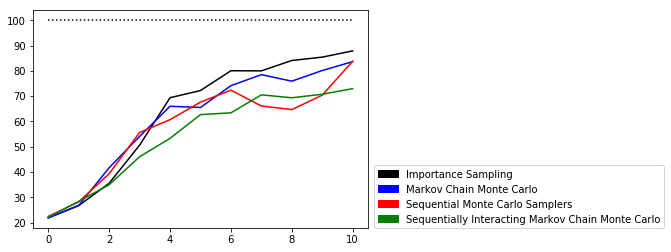

In [76]:
import matplotlib.patches as mpatches

plot_is = plt.plot(rewards_importance_sampling, label='Importance Sampling', color='black')
patch_is = mpatches.Patch(color='black', label='Importance Sampling')

plot_mcmc = plt.plot(rewards_mcmc, label='Markov Chain Monte Carlo', color='blue')
patch_mcmc = mpatches.Patch(color='blue', label='Markov Chain Monte Carlo')

plot_smcs = plt.plot(rewards_smcs, label='Sequential Monte Carlo Samplers', color='red')
patch_smcs = mpatches.Patch(color='red', label='Sequential Monte Carlo Samplers')

plot_simcmc = plt.plot(rewards_simcmc, label='Sequentially Interacting Markov Chain Monte Carlo', color='green')
patch_simcmc = mpatches.Patch(color='green', label='Sequentially Interacting Markov Chain Monte Carlo')

plt.hlines(np.min([horizon,195]), 0, iteration_count, linestyle='dotted')

plt.legend(handles=[patch_is, patch_mcmc, patch_smcs, patch_simcmc], bbox_to_anchor=(0, 0, 1.9, 0.31))

plt.show()

# RLEMMC Experiment

In [77]:
def plot_experiment( experiment_rewards, label=None ):
    
    # Calculate Statistics
    experiment_mean = np.mean(experiment_rewards,axis=0)
    experiment_var = np.var(experiment_rewards,axis=0)
    experiment_max = np.max(experiment_rewards,axis=0)
    experiment_min = np.min(experiment_rewards,axis=0)
    experiment_median = np.median(experiment_rewards,axis=0)
    
    # Mean Average Rewards
    plt.plot(experiment_mean, color='#000099', linewidth=3)

    # Min and Max Results
    plt.plot(experiment_min, '--', color='black')
    plt.plot(experiment_max, '--', color='black')
    plt.fill_between(range(iteration_count+1), experiment_min, experiment_max, color='#ddeeff')

    # Optimal or Exceptable Result
    plt.hlines(np.min([horizon,195]), 0, iteration_count, linestyle='dotted', color='#333333')

    # Axis Limits
    axes = plt.gca()
    axes.set_xlim([0,iteration_count])
    # axes.set_ylim([0,horizon])

IS
...Run 0
...Run 1
...Run 2
...Run 3
...Run 4
...Run 5
...Run 6
...Run 7
...Run 8
...Run 9


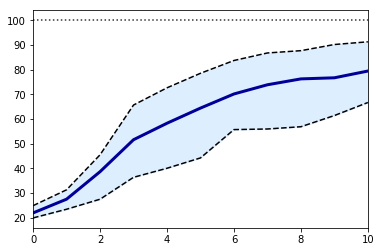

MCMC
...Run 0
...Run 1
...Run 2
...Run 3
...Run 4
...Run 5
...Run 6
...Run 7
...Run 8
...Run 9


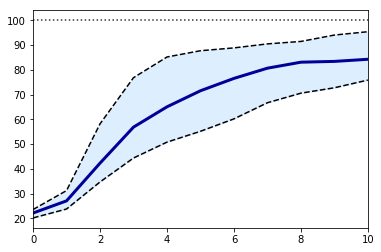

SMCS
...Run 0
...Run 1
...Run 2
...Run 3
...Run 4
...Run 5
...Run 6
...Run 7
...Run 8
...Run 9


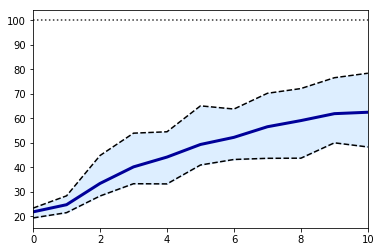

SIMCMC
...Run 0
...Run 1
...Run 2
...Run 3
...Run 4
...Run 5
...Run 6
...Run 7
...Run 8
...Run 9


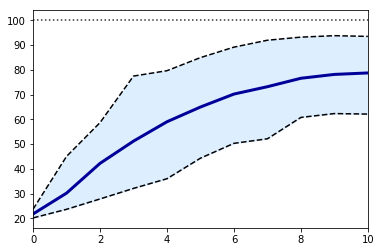

In [78]:
inference_methods = [importance_sampling, mcmc, smcs, simcmc]
inference_names = ['IS','MCMC', 'SMCS', 'SIMCMC']

for m in range(len(inference_methods)):
    print(inference_names[m])
    
    experiment_rewards = np.zeros((experiment_count, iteration_count+1))
    
    for e in range(experiment_count):
        print("...Run " + str(e))
    
        _, experiment_rewards[e] = rlemmc(env, inference_methods[m], policy_approximation )
        
    plot_experiment(experiment_rewards, label=inference_methods[m])
    plt.show()